In [1]:
import pandas as pd

In [4]:
from dbcp.helpers import get_sql_engine

engine = get_sql_engine()

In [10]:
with engine.connect() as con:
    counties_1 = pd.read_sql_table("counties_wide_format", con, schema="data_mart")

In [19]:
counties_1.justice40_dbcp_index.isna().value_counts()

False    3230
True        4
Name: justice40_dbcp_index, dtype: int64

## Load snapshot

In [20]:
import os
import pydata_google_auth

GCP_PROJECT_ID = os.environ.get("GCP_PROJECT_ID")

SCOPES = [
    "https://www.googleapis.com/auth/cloud-platform",
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES, use_local_webserver=False
)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-ka1m0ue4fptfmt9siejdd5lom7p39upa.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fpydata-google-auth.readthedocs.io%2Fen%2Flatest%2Foauth.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=ge1WF8gFk6SZWJiJg7kbZ6SphwSjCO&access_type=offline


Enter the authorization code:  4/0AZEOvhXnXsyw0QjqcCFeDgUrQAEx9bbtLw9TFdYEz2vu1Eh0lYzdazldJxByh2mtByD_ZA


In [26]:
import pandas_gbq

# Update the in-memory credentials cache (added in pandas-gbq 0.7.0).
pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "dbcp-dev-350818"

In [27]:
counties_beta = pandas_gbq.read_gbq("select * from dbcp-dev-350818.data_mart_dev.counties_wide_format_justice40_beta")

Downloading: 100%|██████████|


## Compare

In [13]:
counties_1.justice40_dbcp_index.describe()

count    3230.000000
mean        1.860139
std         1.438222
min         0.000000
25%         0.500000
50%         2.000000
75%         3.000000
max         6.000000
Name: justice40_dbcp_index, dtype: float64

In [28]:
counties_beta.justice40_dbcp_index.describe()

count    3230.000000
mean        1.799536
std         1.508551
min         0.000000
25%         0.000000
50%         1.750000
75%         3.000000
max         6.000000
Name: justice40_dbcp_index, dtype: float64

<AxesSubplot: ylabel='Frequency'>

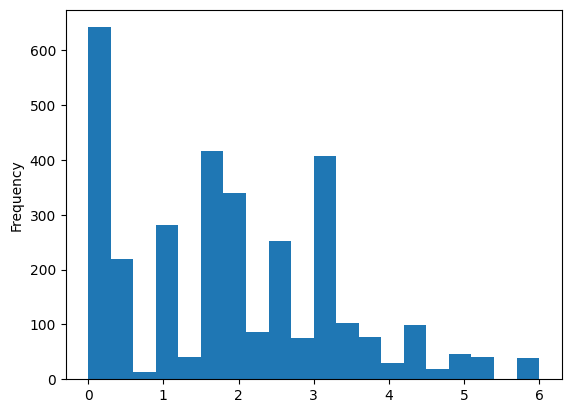

In [15]:
counties_1.justice40_dbcp_index.plot.hist(bins=20)

In [36]:
cols = ["county_id_fips", "justice40_dbcp_index"]

counties_merged = counties_1[cols].merge(counties_beta[cols], on="county_id_fips", how="outer", validate="1:1", suffixes=("_1", "_beta"))

In [37]:
counties_merged

,county_id_fips,justice40_dbcp_index_1,justice40_dbcp_index_beta
0,31039,0.00,0.00
1,53069,0.00,0.00
2,35011,0.50,0.50
3,31109,5.25,4.25
4,31129,2.50,0.00
...,...,...,...
3229,26091,1.50,2.25
3230,27135,0.00,0.00
3231,28089,3.75,3.75
3232,48227,3.00,3.75


- How many counties have different values?
- Of the counties that have new numbers, what's the distribution of how they changed?

In [47]:
# (counties_merged.justice40_dbcp_index_1 - counties_merged.justice40_dbcp_index_beta) / counties_merged.justice40_dbcp_index_beta
counties_merged["index_diff"] = (counties_merged.justice40_dbcp_index_1 - counties_merged.justice40_dbcp_index_beta)

In [50]:
unchanged_index = (counties_merged.index_diff == 0.0)

unchanged_index.value_counts(normalize=True)

True     0.705318
False    0.294682
Name: index_diff, dtype: float64

In [56]:
counties_changed_index = counties_merged[~unchanged_index]

counties_changed_index_pct = counties_changed_index.index_diff / counties_changed_index.justice40_dbcp_index_beta

In [59]:
counties_changed_index_pct.describe()

count    949.000000
mean            inf
std             NaN
min       -1.000000
25%       -0.230769
50%        0.200000
75%        1.500000
max             inf
dtype: float64

<AxesSubplot: >

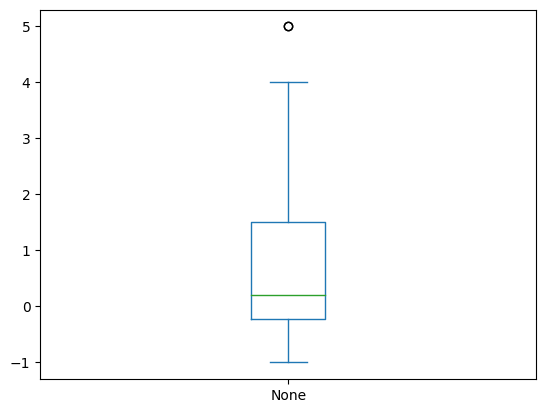

In [58]:
counties_changed_index_pct.plot.box()

In [60]:
counties_changed_index_pct.value_counts()

 inf         200
-0.333333     59
-0.200000     47
-0.272727     44
-0.230769     32
            ... 
 0.083333      1
 0.071429      1
 0.187500      1
-0.066667      1
-0.100000      1
Length: 99, dtype: int64

In [63]:
(counties_changed_index.justice40_dbcp_index_1 > counties_changed_index.justice40_dbcp_index_beta).value_counts()

True     530
False    423
dtype: int64